In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
import random
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib notebook

In [3]:
FTSEStocksEachQuarter = pd.read_csv(r'FTSEStocksEachQuarter.csv')
fullStockListDf = pd.read_csv(r'fullFTSEStockList17-20.csv')
fullStockListDf.drop(columns = 'Unnamed: 0', inplace = True)

FTSE = pd.read_csv(r'FTSE17-20.csv')
FTSE['Date'] = pd.to_datetime(FTSE['Date'])
FTSE=FTSE[FTSE['Date'] > datetime.strptime('Jun 16, 2017', '%b %d, %Y').date()]
FTSE=FTSE[FTSE['Date'] < datetime.strptime('Jan 01, 2020', '%b %d, %Y').date()]


quarterCutOffDates = [   datetime.strptime('Jun 19, 2017', '%b %d, %Y').date(), \
                         datetime.strptime('Sep 18, 2017', '%b %d, %Y').date(), \
                         datetime.strptime('Dec 18, 2017', '%b %d, %Y').date(), \
                         datetime.strptime('Mar 19, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Jun 18, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Sep 24, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Dec 24, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Mar 18, 2019', '%b %d, %Y').date(), \
                         datetime.strptime('Jun 24, 2019', '%b %d, %Y').date(), \
                         datetime.strptime('Sep 23, 2019', '%b %d, %Y').date(),
                          datetime.strptime('Dec 23, 2019', '%b %d, %Y').date()
                        ]
quarterNames = ['Q3,17','Q4,17', 'Q1,18', 'Q2,18', 'Q3,18', 'Q4,18', 'Q1,19', 'Q2,19', 'Q3,19', 'Q4,19']


FTSE=FTSE[FTSE['Date'] > datetime.strptime('Jun 16, 2017', '%b %d, %Y').date()]
if len(quarterCutOffDates) == 10:
    quarterCutOffDates.append(datetime.strptime('Dec 23, 2019', '%b %d, %Y').date())

indexDivisors = pd.DataFrame({'Quarter CO Date': quarterCutOffDates[1:]}, index = quarterNames)
fullStockListDf

,0
0,AAL
1,ABF
2,ADM
3,AHT
4,ANTO
...,...
110,UU.
111,VOD
112,WG.
113,WPP


# Tilt Function 
Input : DataFrame with companies as index names and tilt weights (-2% > tilt > 2%) in 'Weights' column

see below function for example

In [203]:
def tiltFTSE(tilt):
    #iterates over quarter in period
    tilt = tilt.divide(100)
    
    for idx, quarter in enumerate(quarterNames):
        print(quarter)
        #gets index (trading days) for each quarter
        index = FTSE[(FTSE['Date'] >= quarterCutOffDates[idx]) & (FTSE['Date'] < quarterCutOffDates[idx+1])].Date.values

        #imports data for that quarter
        stockWeightsOpen = pd.read_csv(r'companyWeightsEachQuarter/companyWeights{0}Open.csv'.format(quarter))
        stockWeightsOpen.drop(columns = 'Unnamed: 0', inplace = True)
        #print(stockWeightsOpen)
        stockWeightsClose = pd.read_csv(r'companyWeightsEachQuarter/companyWeights{0}Close.csv'.format(quarter))
        stockWeightsClose.drop(columns = 'Unnamed: 0', inplace = True)

        totalMCsOpen = pd.read_csv(r'totalMarketCapsEachQuarter/totalMarketCaps{0}Open.csv'.format(quarter))
        totalMCsOpen.drop(columns = 'Unnamed: 0', inplace = True)
        
        totalMCsClose = pd.read_csv(r'totalMarketCapsEachQuarter/totalMarketCaps{0}Close.csv'.format(quarter))
        totalMCsClose.drop(columns = 'Unnamed: 0', inplace = True)

        #stockMarketCapsEachQuarterOpen = pd.read_csv(r'companyMarketCapsEachQuarter/companyMarketCaps{0}Open.csv'.format(quarter))
        #stockMarketCapsEachQuarterOpen.drop(columns = 'Unnamed: 0', inplace = True)
        
        #stockMarketCapsEachQuarterClose = pd.read_csv(r'companyMarketCapsEachQuarter/companyMarketCaps{0}Close.csv'.format(quarter))
        #stockMarketCapsEachQuarterClose.drop(columns = 'Unnamed: 0', inplace = True)

        
        totalMCsCloseLast = totalMCsClose['0'].iloc[-1]
        sumWeights = totalMCsOpen
        
        stockidx = 0
        
        for stock in FTSEStocksEachQuarter[quarter]:
            
            weightClose = stockWeightsClose[stock].iloc[-1]
            
            #applies tilt to weights and then sums new weights 
            #weight cannot be <0 
            if stockidx == 0:
                sumWeights = pd.Series([(-weight) if tilt.loc[stock][0]+weight<0 else tilt.loc[stock][0] + weight for weight in stockWeightsOpen[stock]])
                
                if tilt.loc[stock][0] + weightClose < 0:
                    sumWeightsLastClose = -weightClose
                else:
                    sumWeightsLastClose = tilt.loc[stock][0] + weightClose
            else:
                sumWeights += pd.Series([(-weight) if tilt.loc[stock][0]+weight<0 else tilt.loc[stock][0] + weight for weight in stockWeightsOpen[stock]])
                
                if tilt.loc[stock][0] + weightClose < 0:
                    sumWeightsLastClose -= weightClose
                else:
                    sumWeightsLastClose += tilt.loc[stock][0] + weightClose
           
            stockidx += 1
            #print(sumWeights)
            
        #gets new market caps based off updated weights
        newTotalMarketCapsOpen = totalMCsOpen['0']* sumWeights
        #finds last closing mc of quarter for index divisor calc
        closeTotalMC = sumWeightsLastClose*totalMCsClose['0'].iloc[-1]
        
        if idx == 0:
            #for the first quarter the reference price is the real FTSE price from that day - abitrary starting point
            indexDivisorForQuarter = newTotalMarketCapsOpen.iloc[0]/(FTSE[FTSE['Date'] == quarterCutOffDates[idx]]['Open'].values[0])
        else:
            indexDivisorForQuarter = newTotalMarketCapsOpen.iloc[0]/quarterClose
        #print(indexDivisorForQuarter,closeTotalMC)

        quarterClose = closeTotalMC / indexDivisorForQuarter
        #calculates new tilted price using index divisor and tilted market caps
        newTotalMarketCapsOpen = newTotalMarketCapsOpen.to_frame()
        FTSEPriceQuarterly = newTotalMarketCapsOpen.divide(indexDivisorForQuarter).set_index(index, drop=True)
        FTSEPriceQuarterly.rename(columns={0:"Open"}, inplace=True)
        #FTSEPriceQuarterly['Close'] = newTotalMarketCapsClose.divide(indexDivisorForQuarter).set_index(index, drop=True)


        if idx == 0:
            FTSEPrice3yr = FTSEPriceQuarterly

        else:
            FTSEPrice3yr = FTSEPrice3yr.append(FTSEPriceQuarterly)

    FTSEPrice3yr.rename(columns={'0':"Open"}, inplace=True)
    
    return FTSEPrice3yr

In [35]:
stockWeightsOpen

NameError: name 'stockWeightsOpen' is not defined

Example Input

In [197]:
tiltWeights = pd.DataFrame(index = fullStockListDf['0'].values)
np.random.seed(0)
tiltWeights['Weights'] = np.random.uniform(-2,2,tiltWeights.shape[0])
#tiltWeights['Weights'] = np.zeros(tiltWeights.shape[0])
#tiltWeights['Weights'] = np.full((tiltWeights.shape[0],1),2)
tiltWeights

,Weights
AAL,0.195254
ABF,0.860757
ADM,0.411054
AHT,0.179533
ANTO,-0.305381
...,...
UU.,-0.211498
VOD,1.385635
WG.,0.797917
WPP,-0.810252


In [204]:
tiltedFTSE = tiltFTSE(tiltWeights)
print(tiltedFTSE)


Q3,17
0    -0.004262
1    -0.004233
2    -0.004243
3    -0.004251
4    -0.004280
        ...   
59   -0.004415
60   -0.004459
61   -0.004450
62   -0.004378
63   -0.004379
Length: 64, dtype: float64
0     0.009514
1     0.009551
2     0.009575
3     0.009547
4     0.009529
        ...   
59    0.009944
60    0.009592
61    0.009693
62    0.009791
63    0.009879
Length: 64, dtype: float64
0     0.015566
1     0.015583
2     0.015615
3     0.015573
4     0.015535
        ...   
59    0.015780
60    0.015423
61    0.015526
62    0.015602
63    0.015703
Length: 64, dtype: float64
0     0.023963
1     0.023972
2     0.023894
3     0.023962
4     0.023980
        ...   
59    0.026895
60    0.026585
61    0.026680
62    0.026384
63    0.026489
Length: 64, dtype: float64
0     0.022638
1     0.022644
2     0.022612
3     0.022663
4     0.022669
        ...   
59    0.025176
60    0.024847
61    0.024968
62    0.024739
63    0.024862
Length: 64, dtype: float64
0     0.028312
1     0.028349
2   

0     0.577813
1     0.578602
2     0.579383
3     0.579868
4     0.579395
        ...   
59    0.575905
60    0.575529
61    0.575117
62    0.574477
63    0.573431
Length: 64, dtype: float64
0     0.580938
1     0.581661
2     0.582447
3     0.582861
4     0.582372
        ...   
59    0.578805
60    0.578443
61    0.578015
62    0.577318
63    0.576336
Length: 64, dtype: float64
0     0.573331
1     0.574050
2     0.574750
3     0.575163
4     0.574760
        ...   
59    0.571267
60    0.570842
61    0.570392
62    0.569759
63    0.568734
Length: 64, dtype: float64
0     0.584075
1     0.584631
2     0.584949
3     0.585642
4     0.585107
        ...   
59    0.580487
60    0.579901
61    0.579995
62    0.579369
63    0.579355
Length: 64, dtype: float64
0     0.577650
1     0.578156
2     0.578428
3     0.579050
4     0.578534
        ...   
59    0.573762
60    0.573094
61    0.573162
62    0.572611
63    0.572542
Length: 64, dtype: float64
0     0.587396
1     0.587885
2     0.58

0     1.088329
1     1.088571
2     1.086696
3     1.085822
4     1.086230
        ...   
59    1.087573
60    1.087376
61    1.086364
62    1.087610
63    1.088408
Length: 64, dtype: float64
0     1.089518
1     1.089698
2     1.087815
3     1.086858
4     1.087219
        ...   
59    1.088626
60    1.088423
61    1.087362
62    1.088590
63    1.089398
Length: 64, dtype: float64
0     1.133024
1     1.133056
2     1.131418
3     1.130640
4     1.131139
        ...   
59    1.131344
60    1.131225
61    1.130012
62    1.131369
63    1.131843
Length: 64, dtype: float64
0     1.142177
1     1.142206
2     1.140555
3     1.139781
4     1.140283
        ...   
59    1.140432
60    1.140310
61    1.139091
62    1.140443
63    1.140936
Length: 64, dtype: float64
0     1.158278
1     1.158309
2     1.156756
3     1.155988
4     1.156467
        ...   
59    1.156447
60    1.156185
61    1.155081
62    1.156395
63    1.156885
Length: 64, dtype: float64
0     1.160586
1     1.160621
2     1.15

0     0.592283
1     0.591895
2     0.590701
3     0.589981
4     0.590363
        ...   
60    0.587742
61    0.588071
62    0.588969
63    0.588803
64    0.587465
Length: 65, dtype: float64
0     0.611264
1     0.610468
2     0.609311
3     0.608482
4     0.608772
        ...   
60    0.604938
61    0.605190
62    0.606120
63    0.605846
64    0.604532
Length: 65, dtype: float64
0     0.611622
1     0.610800
2     0.609616
3     0.608798
4     0.609082
        ...   
60    0.605460
61    0.605740
62    0.606644
63    0.606364
64    0.605057
Length: 65, dtype: float64
0     0.608174
1     0.607330
2     0.606166
3     0.605327
4     0.605602
        ...   
60    0.601424
61    0.601724
62    0.602655
63    0.602337
64    0.600980
Length: 65, dtype: float64
0     0.603187
1     0.602373
2     0.601101
3     0.600361
4     0.600699
        ...   
60    0.596218
61    0.596606
62    0.597583
63    0.597211
64    0.595855
Length: 65, dtype: float64
0     0.626655
1     0.625856
2     0.62

0     1.052000
1     1.051298
2     1.051048
3     1.051558
4     1.053667
        ...   
60    1.052241
61    1.052910
62    1.054779
63    1.054061
64    1.053160
Length: 65, dtype: float64
0     1.062096
1     1.061482
2     1.061194
3     1.061731
4     1.063866
        ...   
60    1.062293
61    1.062927
62    1.064844
63    1.064189
64    1.063080
Length: 65, dtype: float64
0     1.059296
1     1.058667
2     1.058353
3     1.058928
4     1.061074
        ...   
60    1.059474
61    1.060122
62    1.062051
63    1.061384
64    1.060245
Length: 65, dtype: float64
0     1.059266
1     1.058637
2     1.058322
3     1.058898
4     1.061044
        ...   
60    1.059442
61    1.060090
62    1.062019
63    1.061352
64    1.060213
Length: 65, dtype: float64
0     1.070415
1     1.069785
2     1.069596
3     1.070134
4     1.072166
        ...   
60    1.071222
61    1.071857
62    1.073730
63    1.073204
64    1.072041
Length: 65, dtype: float64
0     1.076222
1     1.075609
2     1.07

0     0.362222
1     0.362385
2     0.362177
3     0.361697
4     0.361735
        ...   
57    0.359823
58    0.359950
59    0.358954
60    0.358735
61    0.359065
Length: 62, dtype: float64
0     0.355476
1     0.355602
2     0.355287
3     0.354790
4     0.354852
        ...   
57    0.352728
58    0.352924
59    0.351792
60    0.351602
61    0.351887
Length: 62, dtype: float64
0     0.363424
1     0.363522
2     0.363286
3     0.362824
4     0.362801
        ...   
57    0.360540
58    0.360722
59    0.359536
60    0.359411
61    0.359663
Length: 62, dtype: float64
0     0.369095
1     0.369217
2     0.368946
3     0.368504
4     0.368462
        ...   
57    0.366163
58    0.366346
59    0.365174
60    0.365034
61    0.365263
Length: 62, dtype: float64
0     0.375657
1     0.375804
2     0.375540
3     0.375104
4     0.375081
        ...   
57    0.372877
58    0.373053
59    0.371845
60    0.371724
61    0.371920
Length: 62, dtype: float64
0     0.413425
1     0.413653
2     0.41

0     0.939346
1     0.938459
2     0.937717
3     0.937798
4     0.938802
        ...   
57    0.932741
58    0.931776
59    0.932002
60    0.931080
61    0.930351
Length: 62, dtype: float64
0     0.936598
1     0.935697
2     0.934960
3     0.935028
4     0.936062
        ...   
57    0.929747
58    0.928734
59    0.928950
60    0.927993
61    0.927250
Length: 62, dtype: float64
0     0.942027
1     0.941127
2     0.940385
3     0.940453
4     0.941468
        ...   
57    0.934968
58    0.933944
59    0.934144
60    0.933187
61    0.932415
Length: 62, dtype: float64
0     0.954525
1     0.953606
2     0.952880
3     0.952910
4     0.953882
        ...   
57    0.947883
58    0.946896
59    0.947094
60    0.946162
61    0.945405
Length: 62, dtype: float64
0     0.952122
1     0.951186
2     0.950410
3     0.950438
4     0.951447
        ...   
57    0.945343
58    0.944354
59    0.944584
60    0.943653
61    0.942893
Length: 62, dtype: float64
0     0.968034
1     0.967076
2     0.96

0     0.353830
1     0.353198
2     0.352646
3     0.350743
4     0.351908
        ...   
56    0.363828
57    0.364671
58    0.346052
59    0.346724
60    0.346711
Length: 61, dtype: float64
0     0.359546
1     0.359011
2     0.358466
3     0.356504
4     0.357558
        ...   
56    0.370056
57    0.370877
58    0.352262
59    0.353218
60    0.352940
Length: 61, dtype: float64
0     0.352563
1     0.351972
2     0.351410
3     0.349368
4     0.350486
        ...   
56    0.363334
57    0.363994
58    0.345327
59    0.346223
60    0.345914
Length: 61, dtype: float64
0     0.360322
1     0.359776
2     0.359116
3     0.357082
4     0.358229
        ...   
56    0.371228
57    0.371817
58    0.353159
59    0.354065
60    0.353728
Length: 61, dtype: float64
0     0.365923
1     0.365380
2     0.364706
3     0.362690
4     0.363829
        ...   
56    0.376762
57    0.377332
58    0.358670
59    0.359573
60    0.359232
Length: 61, dtype: float64
0     0.372566
1     0.372032
2     0.37

0     0.890725
1     0.889983
2     0.890749
3     0.890948
4     0.892563
        ...   
56    0.910029
57    0.910071
58    0.892162
59    0.892767
60    0.894020
Length: 61, dtype: float64
0     0.911128
1     0.910411
2     0.911199
3     0.911428
4     0.913050
        ...   
56    0.930263
57    0.930313
58    0.912417
59    0.913020
60    0.914273
Length: 61, dtype: float64
0     0.923545
1     0.922779
2     0.923563
3     0.923740
4     0.925330
        ...   
56    0.942322
57    0.942359
58    0.924489
59    0.925131
60    0.926335
Length: 61, dtype: float64
0     0.932741
1     0.931972
2     0.932755
3     0.932918
4     0.934510
        ...   
56    0.952006
57    0.952030
58    0.934173
59    0.934838
60    0.936070
Length: 61, dtype: float64
0     0.929816
1     0.929016
2     0.929807
3     0.930039
4     0.931661
        ...   
56    0.949433
57    0.949436
58    0.931575
59    0.932253
60    0.933510
Length: 61, dtype: float64
0     0.926588
1     0.925830
2     0.92

0     0.282258
1     0.281713
2     0.282631
3     0.283298
4     0.283212
        ...   
64    0.289078
65    0.288682
66    0.287276
67    0.286890
68    0.285498
Length: 69, dtype: float64
0     0.284790
1     0.284231
2     0.285145
3     0.285785
4     0.285676
        ...   
64    0.291720
65    0.291395
66    0.290015
67    0.289636
68    0.288234
Length: 69, dtype: float64
0     0.300016
1     0.299441
2     0.300404
3     0.301073
4     0.301010
        ...   
64    0.306898
65    0.306719
66    0.305328
67    0.304882
68    0.303503
Length: 69, dtype: float64
0     0.314430
1     0.313835
2     0.314776
3     0.315426
4     0.315338
        ...   
64    0.321360
65    0.321171
66    0.319755
67    0.319267
68    0.317922
Length: 69, dtype: float64
0     0.302520
1     0.301932
2     0.302855
3     0.303560
4     0.303386
        ...   
64    0.308602
65    0.308462
66    0.307198
67    0.306881
68    0.305585
Length: 69, dtype: float64
0     0.291386
1     0.290949
2     0.29

0     0.669836
1     0.668228
2     0.668921
3     0.669855
4     0.669022
        ...   
64    0.670401
65    0.669967
66    0.668085
67    0.668082
68    0.668950
Length: 69, dtype: float64
0     0.683162
1     0.681194
2     0.681658
3     0.682836
4     0.681948
        ...   
64    0.681055
65    0.680813
66    0.679182
67    0.679810
68    0.681066
Length: 69, dtype: float64
0     0.686450
1     0.684488
2     0.684975
3     0.686098
4     0.685215
        ...   
64    0.684367
65    0.684138
66    0.682489
67    0.683045
68    0.684287
Length: 69, dtype: float64
0     0.686233
1     0.684270
2     0.684758
3     0.685877
4     0.684993
        ...   
64    0.684155
65    0.683927
66    0.682280
67    0.682837
68    0.684084
Length: 69, dtype: float64
0     0.697530
1     0.695385
2     0.695732
3     0.697051
4     0.696150
        ...   
64    0.696111
65    0.695865
66    0.694180
67    0.694782
68    0.696044
Length: 69, dtype: float64
0     0.699472
1     0.697340
2     0.69

0     0.135308
1     0.135466
2     0.135511
3     0.135886
4     0.136504
        ...   
60    0.138197
61    0.138083
62    0.138822
63    0.137655
64    0.138001
Length: 65, dtype: float64
0     0.118461
1     0.118647
2     0.118533
3     0.119263
4     0.119749
        ...   
60    0.139411
61    0.139495
62    0.140292
63    0.138897
64    0.139290
Length: 65, dtype: float64
0     0.183479
1     0.183865
2     0.184732
3     0.185931
4     0.186346
        ...   
60    0.203882
61    0.203833
62    0.203970
63    0.202708
64    0.202408
Length: 65, dtype: float64
0     0.224325
1     0.223953
2     0.224599
3     0.225909
4     0.226807
        ...   
60    0.237437
61    0.237583
62    0.237123
63    0.235759
64    0.235484
Length: 65, dtype: float64
0     0.221418
1     0.221049
2     0.221733
3     0.223031
4     0.223937
        ...   
60    0.234571
61    0.234756
62    0.234265
63    0.232899
64    0.232665
Length: 65, dtype: float64
0     0.249730
1     0.249248
2     0.24

0     0.592099
1     0.591659
2     0.591307
3     0.592832
4     0.593510
        ...   
60    0.617498
61    0.619141
62    0.618660
63    0.617184
64    0.618363
Length: 65, dtype: float64
0     0.589210
1     0.588762
2     0.588407
3     0.589947
4     0.590631
        ...   
60    0.614703
61    0.616371
62    0.615877
63    0.614397
64    0.615551
Length: 65, dtype: float64
0     0.620542
1     0.619912
2     0.619302
3     0.620837
4     0.621706
        ...   
60    0.648167
61    0.649687
62    0.648004
63    0.647008
64    0.648452
Length: 65, dtype: float64
0     0.642917
1     0.642479
2     0.641869
3     0.643322
4     0.644125
        ...   
60    0.670034
61    0.671694
62    0.670093
63    0.669059
64    0.670436
Length: 65, dtype: float64
0     0.643013
1     0.642591
2     0.641989
3     0.643488
4     0.644268
        ...   
60    0.670163
61    0.671762
62    0.670137
63    0.669074
64    0.669195
Length: 65, dtype: float64
0     0.649081
1     0.648665
2     0.64

0    -0.003718
1    -0.003605
2    -0.003668
3    -0.003685
4    -0.003613
5    -0.003646
6    -0.003624
7    -0.003671
8    -0.003700
9    -0.003661
10   -0.003703
11   -0.003721
12   -0.003785
13   -0.003751
14   -0.003905
15   -0.003837
16   -0.003768
17   -0.003780
18   -0.003757
19   -0.003847
20   -0.003774
21   -0.003841
22   -0.003793
23   -0.003769
24   -0.003787
25   -0.003746
26   -0.003837
27   -0.003892
28   -0.003921
29   -0.003992
30   -0.003993
31   -0.004046
32   -0.004020
33   -0.004037
34   -0.003979
35   -0.004083
36   -0.004089
37   -0.004089
38   -0.004103
39   -0.004113
40   -0.004136
41   -0.004149
42   -0.004165
43   -0.004178
44   -0.004205
45   -0.004159
46   -0.004207
47   -0.004240
48   -0.004203
49   -0.004203
50   -0.004230
51   -0.004221
52   -0.004206
53   -0.004237
54   -0.004235
55   -0.004260
56   -0.004209
dtype: float64
0     0.008541
1     0.008576
2     0.008493
3     0.008444
4     0.008520
5     0.008548
6     0.008597
7     0.008595
8     0.00

0     0.247396
1     0.247836
2     0.247348
3     0.248330
4     0.246696
5     0.246544
6     0.248142
7     0.250090
8     0.248903
9     0.248085
10    0.246260
11    0.246272
12    0.244859
13    0.245856
14    0.245096
15    0.244996
16    0.246006
17    0.246161
18    0.245861
19    0.245218
20    0.246297
21    0.245665
22    0.246258
23    0.246421
24    0.247631
25    0.248081
26    0.248284
27    0.248354
28    0.248467
29    0.248842
30    0.248257
31    0.248371
32    0.248427
33    0.248065
34    0.248358
35    0.249332
36    0.250626
37    0.251708
38    0.250179
39    0.251515
40    0.251949
41    0.251375
42    0.253202
43    0.253477
44    0.253703
45    0.253109
46    0.253189
47    0.253184
48    0.253561
49    0.254659
50    0.255097
51    0.254638
52    0.255153
53    0.255309
54    0.255190
55    0.255225
56    0.253942
dtype: float64
0     0.244821
1     0.245287
2     0.244800
3     0.245786
4     0.244147
5     0.244054
6     0.245646
7     0.247607
8     0.24

0     0.383799
1     0.383712
2     0.383378
3     0.384457
4     0.383149
5     0.381982
6     0.382586
7     0.384313
8     0.383334
9     0.382133
10    0.379766
11    0.379999
12    0.379163
13    0.379691
14    0.378841
15    0.379339
16    0.380512
17    0.380700
18    0.380844
19    0.380058
20    0.381628
21    0.381153
22    0.381339
23    0.381548
24    0.383108
25    0.383516
26    0.384402
27    0.384269
28    0.384234
29    0.384072
30    0.382988
31    0.383287
32    0.383381
33    0.383256
34    0.383378
35    0.384472
36    0.386045
37    0.387181
38    0.385696
39    0.386902
40    0.386541
41    0.386344
42    0.388163
43    0.388150
44    0.388181
45    0.386548
46    0.386696
47    0.386902
48    0.387339
49    0.388494
50    0.389140
51    0.389338
52    0.389478
53    0.389839
54    0.389835
55    0.389855
56    0.388371
dtype: float64
0     0.389043
1     0.388965
2     0.388675
3     0.389735
4     0.388424
5     0.387287
6     0.387883
7     0.389586
8     0.38

0     0.571722
1     0.572178
2     0.571131
3     0.571099
4     0.569896
5     0.568441
6     0.568948
7     0.570303
8     0.569232
9     0.568210
10    0.565453
11    0.565948
12    0.564715
13    0.565068
14    0.564604
15    0.564867
16    0.566618
17    0.566533
18    0.566416
19    0.565988
20    0.567882
21    0.567486
22    0.568421
23    0.568456
24    0.569373
25    0.568794
26    0.569474
27    0.567931
28    0.566725
29    0.566782
30    0.566112
31    0.566980
32    0.567130
33    0.566552
34    0.567406
35    0.568461
36    0.569864
37    0.571837
38    0.569178
39    0.570154
40    0.570026
41    0.568360
42    0.569997
43    0.570003
44    0.570026
45    0.569173
46    0.569443
47    0.568651
48    0.569946
49    0.570747
50    0.571691
51    0.572458
52    0.573067
53    0.573484
54    0.573080
55    0.572317
56    0.570965
dtype: float64
0     0.581319
1     0.581816
2     0.580673
3     0.580743
4     0.579525
5     0.578115
6     0.578592
7     0.579940
8     0.57

0     0.662555
1     0.663177
2     0.661728
3     0.661764
4     0.660510
5     0.659669
6     0.659931
7     0.661488
8     0.660493
9     0.659775
10    0.656934
11    0.657555
12    0.656113
13    0.656340
14    0.656305
15    0.656538
16    0.658166
17    0.657943
18    0.657788
19    0.657572
20    0.659569
21    0.659446
22    0.660225
23    0.660367
24    0.661307
25    0.660851
26    0.661543
27    0.660029
28    0.658606
29    0.658860
30    0.658008
31    0.658612
32    0.658618
33    0.658029
34    0.658931
35    0.660163
36    0.661880
37    0.663798
38    0.661474
39    0.662656
40    0.662855
41    0.661205
42    0.663111
43    0.663236
44    0.663833
45    0.662866
46    0.663015
47    0.662343
48    0.663536
49    0.664288
50    0.665645
51    0.666841
52    0.667635
53    0.668142
54    0.667646
55    0.666871
56    0.665383
dtype: float64
0     0.664787
1     0.665644
2     0.664059
3     0.664425
4     0.663201
5     0.661884
6     0.661945
7     0.663645
8     0.66

0     0.932436
1     0.934557
2     0.933513
3     0.934021
4     0.932323
5     0.933114
6     0.934578
7     0.934943
8     0.934409
9     0.932923
10    0.930253
11    0.931253
12    0.928567
13    0.929937
14    0.930458
15    0.929180
16    0.930331
17    0.930919
18    0.929636
19    0.928110
20    0.926282
21    0.927128
22    0.928364
23    0.927769
24    0.929326
25    0.932623
26    0.933637
27    0.933375
28    0.934158
29    0.932551
30    0.933354
31    0.931830
32    0.932883
33    0.932495
34    0.934125
35    0.933358
36    0.933633
37    0.935522
38    0.932851
39    0.935268
40    0.934776
41    0.933000
42    0.934856
43    0.934738
44    0.935101
45    0.935074
46    0.934438
47    0.932520
48    0.933628
49    0.933596
50    0.934334
51    0.934854
52    0.933818
53    0.934675
54    0.934149
55    0.935488
56    0.934747
dtype: float64
0     0.942053
1     0.944107
2     0.943070
3     0.943568
4     0.941874
5     0.942630
6     0.944047
7     0.944406
8     0.94

0     1.011083
1     1.012972
2     1.011839
3     1.012558
4     1.010843
5     1.011566
6     1.013001
7     1.012954
8     1.012241
9     1.010833
10    1.008327
11    1.009448
12    1.007095
13    1.008422
14    1.008831
15    1.007733
16    1.008737
17    1.009339
18    1.008119
19    1.006769
20    1.005212
21    1.005994
22    1.007246
23    1.006554
24    1.007962
25    1.010854
26    1.011959
27    1.011695
28    1.012375
29    1.010763
30    1.011604
31    1.010249
32    1.011124
33    1.010534
34    1.012069
35    1.011014
36    1.011139
37    1.013025
38    1.010269
39    1.012216
40    1.011653
41    1.009857
42    1.011563
43    1.011771
44    1.011977
45    1.012013
46    1.011696
47    1.009787
48    1.010820
49    1.010763
50    1.011443
51    1.012178
52    1.011096
53    1.011748
54    1.011361
55    1.012503
56    1.011734
dtype: float64
0     1.008781
1     1.010677
2     1.009544
3     1.010248
4     1.008522
5     1.009253
6     1.010687
7     1.010642
8     1.00

Q2,19
0    -0.004167
1    -0.004192
2    -0.004213
3    -0.004152
4    -0.004166
        ...   
61   -0.004381
62   -0.004367
63   -0.004376
64   -0.004414
65   -0.004482
Length: 66, dtype: float64
0     0.008120
1     0.008116
2     0.008129
3     0.008142
4     0.008201
        ...   
61    0.008087
62    0.008047
63    0.008010
64    0.007937
65    0.007903
Length: 66, dtype: float64
0     0.013917
1     0.013893
2     0.013908
3     0.013879
4     0.013949
        ...   
61    0.013761
62    0.013731
63    0.013662
64    0.013597
65    0.013571
Length: 66, dtype: float64
0     0.025278
1     0.025329
2     0.025211
3     0.025480
4     0.025475
        ...   
61    0.025590
62    0.025584
63    0.025641
64    0.025513
65    0.025468
Length: 66, dtype: float64
0     0.023833
1     0.023846
2     0.023755
3     0.023985
4     0.023976
        ...   
61    0.024290
62    0.024279
63    0.024296
64    0.024163
65    0.024141
Length: 66, dtype: float64
0     0.029812
1     0.029778
2   

Length: 66, dtype: float64
0     0.578117
1     0.579042
2     0.579180
3     0.580727
4     0.580718
        ...   
61    0.571206
62    0.571364
63    0.571783
64    0.571870
65    0.571030
Length: 66, dtype: float64
0     0.579915
1     0.580833
2     0.580978
3     0.582511
4     0.582493
        ...   
61    0.572674
62    0.572820
63    0.573220
64    0.573265
65    0.572422
Length: 66, dtype: float64
0     0.572203
1     0.573150
2     0.573355
3     0.575115
4     0.575102
        ...   
61    0.565609
62    0.565747
63    0.566279
64    0.566254
65    0.565466
Length: 66, dtype: float64
0     0.579948
1     0.580949
2     0.581120
3     0.582489
4     0.581921
        ...   
61    0.570519
62    0.570555
63    0.570979
64    0.571384
65    0.570316
Length: 66, dtype: float64
0     0.572417
1     0.573446
2     0.573565
3     0.575166
4     0.574655
        ...   
61    0.562111
62    0.562140
63    0.562624
64    0.562955
65    0.561879
Length: 66, dtype: float64
0     0.58293

0     1.094703
1     1.095940
2     1.094778
3     1.098849
4     1.098433
        ...   
61    1.097347
62    1.097356
63    1.098689
64    1.098300
65    1.097568
Length: 66, dtype: float64
0     1.126324
1     1.127505
2     1.126555
3     1.130403
4     1.130072
        ...   
61    1.126585
62    1.126509
63    1.127814
64    1.127386
65    1.126736
Length: 66, dtype: float64
0     1.143108
1     1.144228
2     1.143293
3     1.147051
4     1.146715
        ...   
61    1.142950
62    1.142830
63    1.143967
64    1.143609
65    1.142876
Length: 66, dtype: float64
0     1.138277
1     1.139378
2     1.138369
3     1.142199
4     1.141998
        ...   
61    1.137670
62    1.137494
63    1.138616
64    1.138212
65    1.137507
Length: 66, dtype: float64
Q3,19
0    -0.004818
1    -0.004841
2    -0.004979
3    -0.004996
4    -0.005036
        ...   
59   -0.005089
60   -0.005210
61   -0.005267
62   -0.005193
63   -0.005146
Length: 64, dtype: float64
0     0.007823
1     0.007774
2   

0     0.574569
1     0.574342
2     0.574727
3     0.574503
4     0.574001
        ...   
59    0.575671
60    0.591508
61    0.591489
62    0.590711
63    0.591393
Length: 64, dtype: float64
0     0.573436
1     0.573197
2     0.573581
3     0.573365
4     0.572841
        ...   
59    0.574228
60    0.590074
61    0.590062
62    0.589276
63    0.590010
Length: 64, dtype: float64
0     0.582474
1     0.582242
2     0.582620
3     0.582462
4     0.581987
        ...   
59    0.583342
60    0.599102
61    0.599094
62    0.598374
63    0.599069
Length: 64, dtype: float64
0     0.582453
1     0.582222
2     0.582599
3     0.582441
4     0.581965
        ...   
59    0.583321
60    0.599081
61    0.599073
62    0.598354
63    0.599049
Length: 64, dtype: float64
0     0.584068
1     0.583796
2     0.584213
3     0.584016
4     0.583539
        ...   
59    0.584970
60    0.600734
61    0.600752
62    0.600083
63    0.600753
Length: 64, dtype: float64
0     0.576553
1     0.576245
2     0.57

0     1.042436
1     1.041589
2     1.043056
3     1.042791
4     1.041139
        ...   
59    1.019469
60    1.034386
61    1.034434
62    1.034929
63    1.035486
Length: 64, dtype: float64
0     1.046827
1     1.045967
2     1.047446
3     1.047196
4     1.045598
        ...   
59    1.024175
60    1.039119
61    1.039100
62    1.039623
63    1.040136
Length: 64, dtype: float64
0     1.091405
1     1.090760
2     1.092087
3     1.091599
4     1.090123
        ...   
59    1.069025
60    1.083931
61    1.084442
62    1.084867
63    1.085305
Length: 64, dtype: float64
0     1.091916
1     1.091291
2     1.092606
3     1.092098
4     1.090598
        ...   
59    1.069544
60    1.084448
61    1.084994
62    1.085413
63    1.085886
Length: 64, dtype: float64
0     1.122264
1     1.121483
2     1.122467
3     1.122283
4     1.121140
        ...   
59    1.104420
60    1.119203
61    1.119768
62    1.120007
63    1.120904
Length: 64, dtype: float64
0     1.138502
1     1.137703
2     1.13

0     0.565493
1     0.565126
2     0.565368
3     0.565622
4     0.565149
        ...   
60    0.548225
61    0.550268
62    0.550474
63    0.551240
64    0.551848
Length: 65, dtype: float64
0     0.578313
1     0.577773
2     0.577750
3     0.577529
4     0.576311
        ...   
60    0.559475
61    0.561272
62    0.561495
63    0.562438
64    0.563042
Length: 65, dtype: float64
0     0.581039
1     0.580435
2     0.580450
3     0.580204
4     0.579012
        ...   
60    0.562042
61    0.563870
62    0.564047
63    0.565030
64    0.565626
Length: 65, dtype: float64
0     0.576909
1     0.576317
2     0.576271
3     0.576044
4     0.574893
        ...   
60    0.557934
61    0.559774
62    0.559894
63    0.560866
64    0.561477
Length: 65, dtype: float64
0     0.573278
1     0.572708
2     0.572614
3     0.572455
4     0.571389
        ...   
60    0.553116
61    0.554966
62    0.555188
63    0.556157
64    0.556770
Length: 65, dtype: float64
0     0.597107
1     0.596506
2     0.59

0     0.941484
1     0.941355
2     0.939318
3     0.941677
4     0.941801
        ...   
60    0.910491
61    0.911719
62    0.914585
63    0.916097
64    0.916725
Length: 65, dtype: float64
0     0.956836
1     0.956743
2     0.954837
3     0.957166
4     0.957343
        ...   
60    0.925100
61    0.926376
62    0.929368
63    0.930837
64    0.931488
Length: 65, dtype: float64
0     0.954595
1     0.954539
2     0.952585
3     0.954919
4     0.955115
        ...   
60    0.922585
61    0.923854
62    0.926881
63    0.928333
64    0.928999
Length: 65, dtype: float64
0     0.970944
1     0.970740
2     0.968799
3     0.971143
4     0.971292
        ...   
60    0.938928
61    0.940242
62    0.943309
63    0.944740
64    0.945413
Length: 65, dtype: float64
0     0.968114
1     0.967972
2     0.966026
3     0.968434
4     0.968572
        ...   
60    0.935670
61    0.936972
62    0.940025
63    0.941448
64    0.942110
Length: 65, dtype: float64
0     0.965231
1     0.965086
2     0.96

<IPython.core.display.Javascript object>


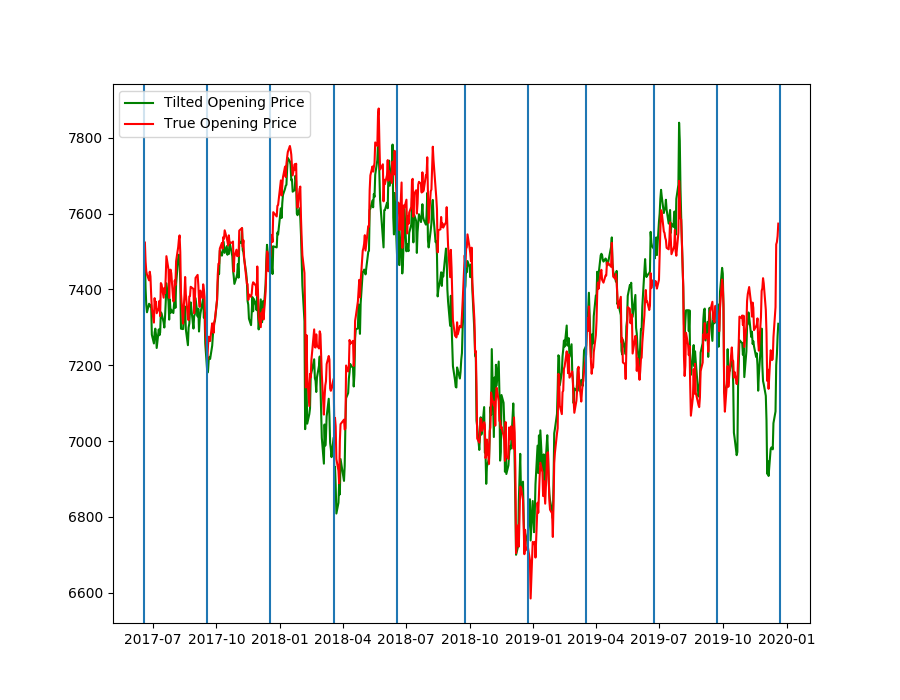

In [205]:
FTSEq317 = FTSE[(FTSE['Date'] > quarterCutOffDates[0]) & (FTSE['Date'] < quarterCutOffDates[10])]['Open'].values
FTSEq317date = FTSE[(FTSE['Date'] > quarterCutOffDates[0]) & (FTSE['Date'] < quarterCutOffDates[10])]['Date'].values

f = plt.figure(figsize=(9,7))
axs = f.add_subplot(111)
axs.plot(tiltedFTSE.index.values,tiltedFTSE['Open'].values,'g', label = 'Tilted Opening Price')
axs.plot(FTSEq317date,FTSEq317,'r', label = 'True Opening Price')
axs.legend()
for quarter in quarterCutOffDates:
    axs.axvline(x=quarter)